In [47]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import lightgbm as lgb
import bisect
from tqdm import tqdm
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
import seaborn as sns

In [6]:
train = pd.read_csv('train.csv').drop(columns=['SAMPLE_ID'])

In [7]:
train

,ARI_CO,ARI_PO,SHIP_TYPE_CATEGORY,DIST,ATA,ID,BREADTH,BUILT,DEADWEIGHT,DEPTH,...,V_WIND,AIR_TEMPERATURE,BN,ATA_LT,DUBAI,BRENT,WTI,BDI_ADJ,PORT_SIZE,CI_HOUR
0,CN,EKP8,Bulk,30.736578,2020-10-15 4:03,Z517571,30.0,28,73100,20.0,...,3.77,15.9,2.730798,12,42.01,43.16,40.96,1407.668330,0.001660,3.048333
1,CN,EUC8,Container,63.220425,2019-09-17 2:55,U467618,30.0,15,37900,20.0,...,-6.72,24.5,4.289058,10,67.53,64.55,59.34,2089.046774,0.001614,17.138611
2,CN,NGG6,Container,90.427421,2019-02-23 6:43,V378315,50.0,7,115000,20.0,...,0.00,9.4,0.000000,14,65.30,66.39,56.94,603.193047,0.001743,98.827500
3,JP,TMR7,Cargo,0.000000,2020-09-18 22:06,B726632,10.0,33,1490,10.0,...,-7.31,22.1,4.693735,7,43.02,43.15,41.11,1169.853455,0.000069,0.000000
4,RU,NNC2,Container,8.813725,2022-08-13 12:57,D215135,30.0,10,27600,10.0,...,2.31,22.8,2.345875,14,90.45,93.65,88.11,1107.944894,0.000197,96.030556
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
359851,SG,GIW5,Cargo,18.618411,2021-04-05 7:58,X755245,20.0,15,14100,10.0,...,-2.00,30.4,1.790550,15,61.34,62.74,59.33,1841.347538,0.002615,25.884444
359852,TW,EKP8,Bulk,0.000000,2015-05-12 20:33,G416557,30.0,14,35100,10.0,...,NaN,NaN,NaN,4,62.40,66.86,60.75,583.328724,0.000427,0.000000
359853,IN,UJM2,Bulk,32.962601,2015-12-22 4:46,O452654,30.0,8,61300,20.0,...,NaN,NaN,NaN,10,32.83,37.89,38.10,471.884296,0.000217,60.282778
359854,CN,WEY7,Bulk,23.631395,2021-03-21 15:11,C824278,30.0,11,58400,20.0,...,3.31,6.2,2.516733,23,63.00,60.79,57.76,2012.150543,0.001028,47.018333


In [32]:
# 선박 종류는 4가지
train['SHIP_TYPE_CATEGORY'].unique()

array(['Bulk', 'Container', 'Cargo', 'Tanker'], dtype=object)

In [37]:
train['SHIP_TYPE_CATEGORY'].value_counts()

Container    152614
Bulk         150951
Cargo         37428
Tanker        18863
Name: SHIP_TYPE_CATEGORY, dtype: int64

대기시간 확인

In [38]:
train['CI_HOUR'].describe()

count    359855.000000
mean         61.880707
std         170.549879
min           0.000000
25%           0.000000
50%           7.949167
75%          49.151389
max        2159.130556
Name: CI_HOUR, dtype: float64

<ipython-input-53-a9339b85d2b5>:2: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(train['CI_HOUR'], shade=True)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 48128 (\N{HANGUL SYLLABLE MIL}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 46020 (\N{HANGUL SYLLABLE DO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44050 (\N{HANGUL SYLLABLE GABS}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51032 (\N{HANGUL SYLLABLE YI}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw

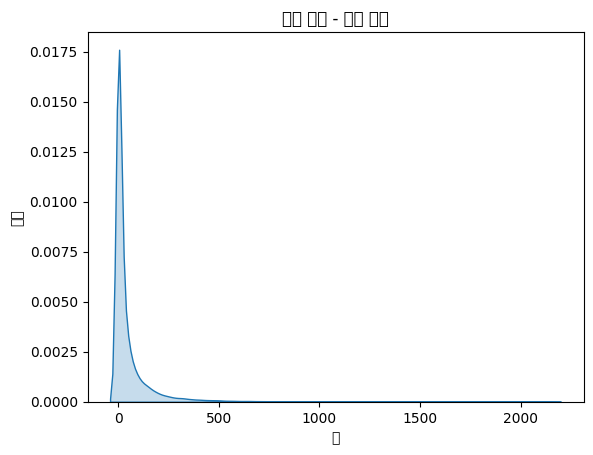

In [53]:
# 데이터프레임의 열에서 밀도 그림 그리기
sns.kdeplot(train['CI_HOUR'], shade=True)
plt.xlabel('값')
plt.ylabel('밀도')
plt.title('값의 분포 - 밀도 그림')
plt.show()

In [42]:
train['CI_HOUR'].isnull().sum()
# 결측치 딱 한개 존재

1

In [50]:
# 데이터 분할
filtered_75 = train[(train['CI_HOUR'] > train['CI_HOUR'].quantile(0.75))]
filtered_50 = train[(train['CI_HOUR'] < train['CI_HOUR'].quantile(0.75)) & (train['CI_HOUR'] > train['CI_HOUR'].quantile(0.25))]
filtered_25 = train[(train['CI_HOUR'] < train['CI_HOUR'].quantile(0.25))]

In [51]:
print(filtered_75['ARI_CO'].value_counts())
print(filtered_50['ARI_CO'].value_counts())
print(filtered_25['ARI_CO'].value_counts())

CN    29822
AU    15860
SG    10527
JP     7735
BR     5313
RU     3884
CA     3637
IN     3299
TW     2570
KR     1110
US     1091
ID      920
UA      832
ZA      742
MZ      742
PE      340
VN      304
QA      282
TT      272
LV      269
MY      237
CL      101
VE       35
FI       31
PH        8
Name: ARI_CO, dtype: int64
CN    49544
SG    17705
JP    15975
TW    10022
AU     8161
IN     4780
RU     4684
CA     2383
ID     2309
KR     1953
BR     1885
UA     1020
US      828
LV      817
MZ      775
QA      692
TT      678
VN      482
PE      274
ZA      265
MY      163
FI       86
CL       65
PH       28
VE       10
Name: ARI_CO, dtype: int64
Series([], Name: ARI_CO, dtype: int64)


나라별 들어온 선박 수

['CN' 'JP' 'RU' 'AU' 'SG' 'ZA' 'KR' 'TW' 'TT' 'ID' 'BR' 'QA' 'LV' 'MZ'
 'US' 'IN' 'UA' 'CA' 'MY' 'PE' 'VN' 'FI' 'CL' 'VE' 'PH']
CN    130021
JP     48430
SG     40338
AU     30301
TW     29966
IN     14854
RU     13225
CA      9930
KR      9779
BR      8629
ID      5382
US      4043
UA      3095
MZ      1953
LV      1936
QA      1658
ZA      1514
VN      1453
TT      1093
PE       821
MY       780
CL       249
FI       233
VE        89
PH        84
Name: ARI_CO, dtype: int64


<ipython-input-16-af01529f03c2>:18: UserWarning: Glyph 45208 (\N{HANGUL SYLLABLE NA}) missing from current font.
  plt.tight_layout()
<ipython-input-16-af01529f03c2>:18: UserWarning: Glyph 46972 (\N{HANGUL SYLLABLE RA}) missing from current font.
  plt.tight_layout()
<ipython-input-16-af01529f03c2>:18: UserWarning: Glyph 49440 (\N{HANGUL SYLLABLE SEON}) missing from current font.
  plt.tight_layout()
<ipython-input-16-af01529f03c2>:18: UserWarning: Glyph 48149 (\N{HANGUL SYLLABLE BAG}) missing from current font.
  plt.tight_layout()
<ipython-input-16-af01529f03c2>:18: UserWarning: Glyph 51221 (\N{HANGUL SYLLABLE JEONG}) missing from current font.
  plt.tight_layout()
<ipython-input-16-af01529f03c2>:18: UserWarning: Glyph 54943 (\N{HANGUL SYLLABLE HOES}) missing from current font.
  plt.tight_layout()
<ipython-input-16-af01529f03c2>:18: UserWarning: Glyph 49688 (\N{HANGUL SYLLABLE SU}) missing from current font.
  plt.tight_layout()
<ipython-input-16-af01529f03c2>:18: UserWarning: Glyph

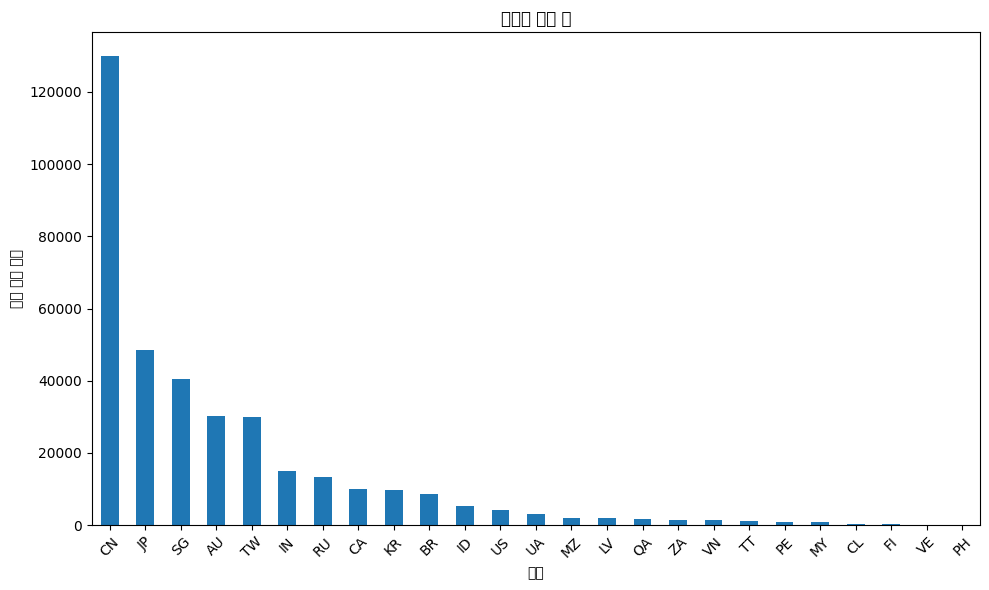

In [16]:
# 도착항 소속 국가 종류
print(train['ARI_CO'].unique())
print(train['ARI_CO'].value_counts())

# 데이터프레임에서 'ARI_CO' 열의 값을 카운트
value_counts = train['ARI_CO'].value_counts()

# 막대 그래프
plt.figure(figsize=(10, 6))

value_counts.plot(kind='bar')
plt.xlabel('나라')
plt.ylabel('선박 정박 횟수')
plt.title('나라별 정박 수')

plt.xticks(rotation=45)

plt.tight_layout()

plt.show()

 중국 항구별 들어온 선박 수

In [28]:
train_cn = train[train['ARI_CO']=='CN'].reset_index()
train_cn

,index,ARI_CO,ARI_PO,SHIP_TYPE_CATEGORY,DIST,ATA,ID,BREADTH,BUILT,DEADWEIGHT,...,V_WIND,AIR_TEMPERATURE,BN,ATA_LT,DUBAI,BRENT,WTI,BDI_ADJ,PORT_SIZE,CI_HOUR
0,0,CN,EKP8,Bulk,30.736578,2020-10-15 4:03,Z517571,30.0,28,73100,...,3.77,15.9,2.730798,12,42.01,43.16,40.96,1407.668330,0.001660,3.048333
1,1,CN,EUC8,Container,63.220425,2019-09-17 2:55,U467618,30.0,15,37900,...,-6.72,24.5,4.289058,10,67.53,64.55,59.34,2089.046774,0.001614,17.138611
2,2,CN,NGG6,Container,90.427421,2019-02-23 6:43,V378315,50.0,7,115000,...,0.00,9.4,0.000000,14,65.30,66.39,56.94,603.193047,0.001743,98.827500
3,5,CN,NGG6,Container,81.435335,2015-09-08 14:24,Z156413,30.0,22,18100,...,NaN,NaN,NaN,22,45.75,48.89,45.92,820.288044,0.001743,42.078056
4,10,CN,EKP8,Container,32.565205,2018-08-14 3:33,B336786,30.0,23,25600,...,NaN,NaN,NaN,11,70.66,70.76,65.01,1610.724314,0.001660,31.891944
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
130016,359846,CN,EKP8,Bulk,0.000000,2021-08-26 3:56,U113751,30.0,8,61300,...,-1.98,26.0,2.024282,11,70.11,71.07,67.42,3608.480980,0.001660,0.000000
130017,359847,CN,TXO3,Bulk,0.000000,2022-05-12 8:57,Y472727,30.0,17,83000,...,-0.98,14.8,2.775813,16,102.81,107.45,106.13,2511.841751,0.000332,0.000000
130018,359850,CN,NGG6,Container,108.966348,2018-03-19 15:32,H264577,30.0,23,21000,...,NaN,NaN,NaN,23,63.89,69.47,65.17,1050.501941,0.001743,40.765556
130019,359854,CN,WEY7,Bulk,23.631395,2021-03-21 15:11,C824278,30.0,11,58400,...,3.31,6.2,2.516733,23,63.00,60.79,57.76,2012.150543,0.001028,47.018333


In [31]:
print(train_cn['ARI_PO'].unique())
print(train_cn['ARI_PO'].value_counts())

['EKP8' 'EUC8' 'NGG6' 'QQW1' 'WEY7' 'UVK6' 'JEN5' 'YRT6' 'NCU8' 'JTD1'
 'TDA5' 'WAF5' 'XVZ3' 'TXO3' 'BGX4' 'SXD2' 'FTQ1' 'JDG8' 'RGT8']
NGG6    26701
EUC8    20805
EKP8    18081
NCU8    10049
WEY7     7832
JEN5     7813
JTD1     6908
QQW1     6636
YRT6     6582
TDA5     6005
XVZ3     3269
UVK6     2409
TXO3     2382
WAF5     2050
SXD2      995
BGX4      856
JDG8      335
FTQ1      308
RGT8        5
Name: ARI_PO, dtype: int64
